In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importamos los datasets preparados 

X_train = pd.read_pickle("dataset/processed_data/linear/Xlm_train.pkl")
X_test = pd.read_pickle("dataset/processed_data/linear/Xlm_test.pkl")
y_train = pd.read_pickle("dataset/processed_data/linear/ylm_train.pkl")
y_test = pd.read_pickle("dataset/processed_data/linear/ylm_test.pkl")

In [3]:
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [4]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns) 
print(importancia_predictores)

LotFrontage     0.000000
LotArea         0.052507
OverallQual     0.104014
OverallCond     0.055579
YearBuilt       0.079689
                  ...   
ExterQual       0.031511
KitchenQual     0.048212
GarageQual      0.002213
Neighborhood    0.000000
ExterCond       0.000000
Length: 62, dtype: float64


In [5]:
predictores_elegidos = importancia_predictores[abs(importancia_predictores) > 0.04].index
print(predictores_elegidos)


Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea',
       'GarageCars', 'Exterior1st_BrkFace', 'KitchenQual'],
      dtype='object')


In [6]:
print(len(predictores_elegidos))

8


In [7]:
joblib.dump(predictores_elegidos, "modelos/elastic_net/predictores_elastic_net.pkl")

['modelos/elastic_net/predictores_elastic_net.pkl']

In [8]:
predicciones_en = elastic_net.predict(X_test)


In [9]:
rmse = root_mean_squared_error(y_test, predicciones_en)
r2 = r2_score(y_test, predicciones_en)

In [10]:
print(f"✅ Desempeno Elastic Net:")
print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

✅ Desempeno Elastic Net:
Test RMSE: 0.13
R² Score: 0.891


In [11]:
predicciones_real = np.expm1(predicciones_en)  
y_test_real = np.expm1(y_test)

In [12]:
rmse_real = root_mean_squared_error(y_test_real, predicciones_real)
print(rmse_real)

23204.823032420587


In [13]:
margen_error = (rmse_real / y_test_real.mean()) * 100

In [14]:
print(margen_error)

13.460082258256314


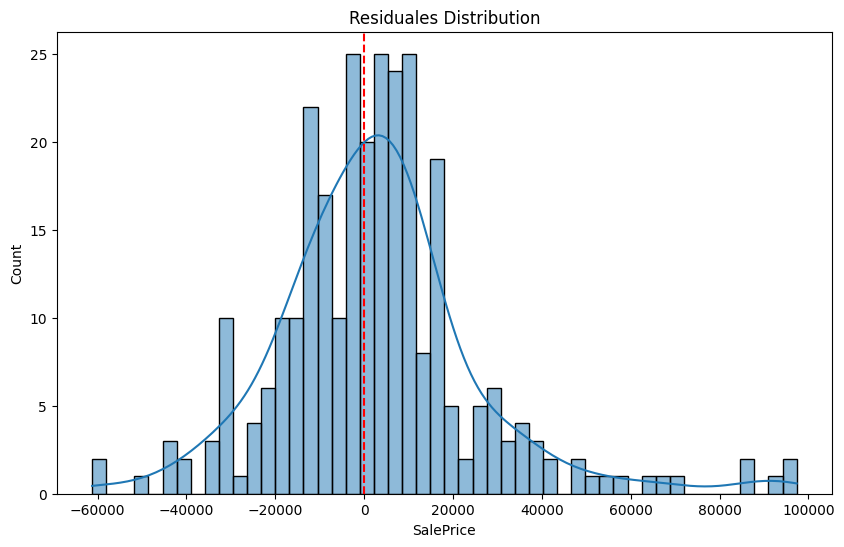

In [15]:
# Analisis del rendimiento 

residuales = y_test_real - predicciones_real

plt.figure(figsize=(10,6))
sns.histplot(residuales, bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title("Residuales Distribution")
plt.show()

In [16]:
df_resultados1 = pd.DataFrame({"Real": y_test_real, "Predicciones": predicciones_real, "Residuales": residuales})
df_resultados1.sort_values(by="Residuales", ascending=False).head(10)


,Real,Predicciones,Residuales
185,475000.0,377635.999553,97364.000447
1243,465000.0,370787.938038,94212.061962
112,383970.0,291365.880357,92604.119643
678,372500.0,285926.770327,86573.229673
313,375000.0,288497.236707,86502.763293
718,341000.0,269096.393731,71903.606269
278,415298.0,349227.976030,66070.023970
644,370878.0,307568.342235,63309.657765
457,256000.0,197720.988988,58279.011012
864,250580.0,197571.424867,53008.575133


In [17]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns).sort_values(ascending=False)
print(importancia_predictores.head(30))


GrLivArea              0.149871
OverallQual            0.104014
YearBuilt              0.079689
Exterior1st_BrkFace    0.055579
OverallCond            0.055579
LotArea                0.052507
GarageCars             0.050516
KitchenQual            0.048212
ExterQual              0.031511
GarageType_Attchd      0.030659
LandContour_HLS        0.025707
LandSlope_Mod          0.024077
MSZoning_RL            0.023007
Exterior1st_CemntBd    0.020251
Foundation_PConc       0.018160
BldgType_TwnhsE        0.012751
Exterior1st_MetalSd    0.009307
LotConfig_CulDSac      0.007493
LandContour_Lvl        0.005894
GarageQual             0.002213
Street_Pave            0.000000
LotConfig_FR3          0.000000
LotConfig_Inside      -0.000000
LandSlope_Sev         -0.000000
BldgType_2fmCon        0.000000
LotConfig_FR2         -0.000000
LandContour_Low        0.000000
LotFrontage            0.000000
MSZoning_FV            0.000000
MSZoning_RH            0.000000
dtype: float64


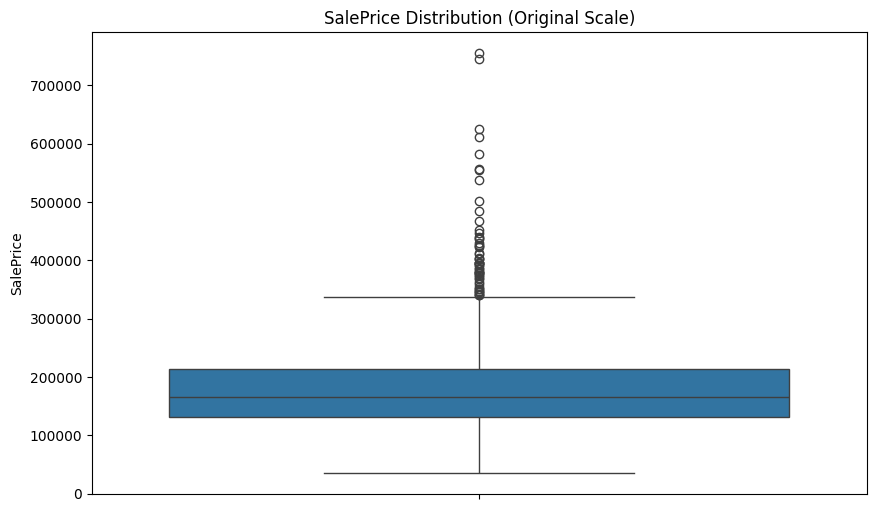

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(y=np.expm1(y_train))  # Reverse log transformation
plt.title("SalePrice Distribution (Original Scale)")
plt.show()

In [19]:
df_train_results = pd.DataFrame({"SalePrice": np.expm1(y_train)})
df_train_results["Z-Score"] = (df_train_results["SalePrice"] - df_train_results["SalePrice"].mean()) / df_train_results["SalePrice"].std()
df_train_results.sort_values(by="SalePrice", ascending=False).head(20)  # Check highest prices


,SalePrice,Z-Score
691,755000.0,7.049721
1182,745000.0,6.926456
1169,625000.0,5.447278
898,611657.0,5.282805
803,582933.0,4.928739
1046,556581.0,4.603912
440,555000.0,4.584424
769,538000.0,4.374873
178,501837.0,3.929111
798,485000.0,3.721569


In [20]:
upper_limit = np.expm1(y_train).quantile(0.99)  # Top 1%

# Filter out extreme expensive homes
y_train_filtered = y_train[np.expm1(y_train) < upper_limit]
X_train_filtered = X_train.loc[y_train_filtered.index] 

In [21]:
elastic_net2 = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net2.fit(X_train_filtered, y_train_filtered)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [22]:
predicciones2 = elastic_net2.predict(X_test)

In [23]:
predicciones2_reales = np.expm1(predicciones2)
rmse2_real = root_mean_squared_error(y_test_real, predicciones2_reales)
print(rmse2_real)

24180.475101245902


In [24]:
margen_error2 = (rmse2_real / y_test_real.mean()) * 100
print(margen_error2)

14.02601448206508


In [25]:
# Assuming top_features is defined as before
top_features = importancia_predictores[abs(importancia_predictores) > 0.015].index

# Create dictionaries to hold interaction terms
interaction_features_train = {}
interaction_features_test = {}

# Create interaction terms without fragmenting the DataFrame
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        feat_name = f"{top_features[i]}_{top_features[j]}_inter"
        interaction_features_train[feat_name] = X_train_filtered[top_features[i]] * X_train_filtered[top_features[j]]
        interaction_features_test[feat_name] = X_test[top_features[i]] * X_test[top_features[j]]

# Convert dictionaries to DataFrames
interaction_df_train = pd.DataFrame(interaction_features_train, index=X_train_filtered.index)
interaction_df_test = pd.DataFrame(interaction_features_test, index=X_test.index)

# Concatenate all new features at once
X_train_enhanced = pd.concat([X_train_filtered, interaction_df_train], axis=1)
X_test_enhanced = pd.concat([X_test, interaction_df_test], axis=1)

# Continue with model training as before
elastic_net_enhanced = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1],
    alphas=np.logspace(-5, 3, 100),
    cv=10,
    max_iter=25000,
    tol=1e-5,
    random_state=42
)

elastic_net_enhanced.fit(X_train_enhanced, y_train_filtered)
predicciones_enhanced = elastic_net_enhanced.predict(X_test_enhanced)
predicciones_enhanced_real = np.expm1(predicciones_enhanced)
rmse_enhanced = root_mean_squared_error(y_test_real, predicciones_enhanced_real)
margen_error_enhanced = (rmse_enhanced / y_test_real.mean()) * 100

print(f"Original Error Margin: {margen_error2:.2f}%")
print(f"Enhanced Error Margin: {margen_error_enhanced:.2f}%")


Original Error Margin: 14.03%
Enhanced Error Margin: 13.31%
